## Full Hamiltonian simulations using optimal parameters


=== Running ORIGINAL full model only ===
omega/2pi (GHz)   = 1.5129999999999997
omega_p/2pi (GHz) = 3.0018333333333334
phase_frac        = 0.5
[cond] mean p = 0.7742725668100341 min p = 0.42817700058405656


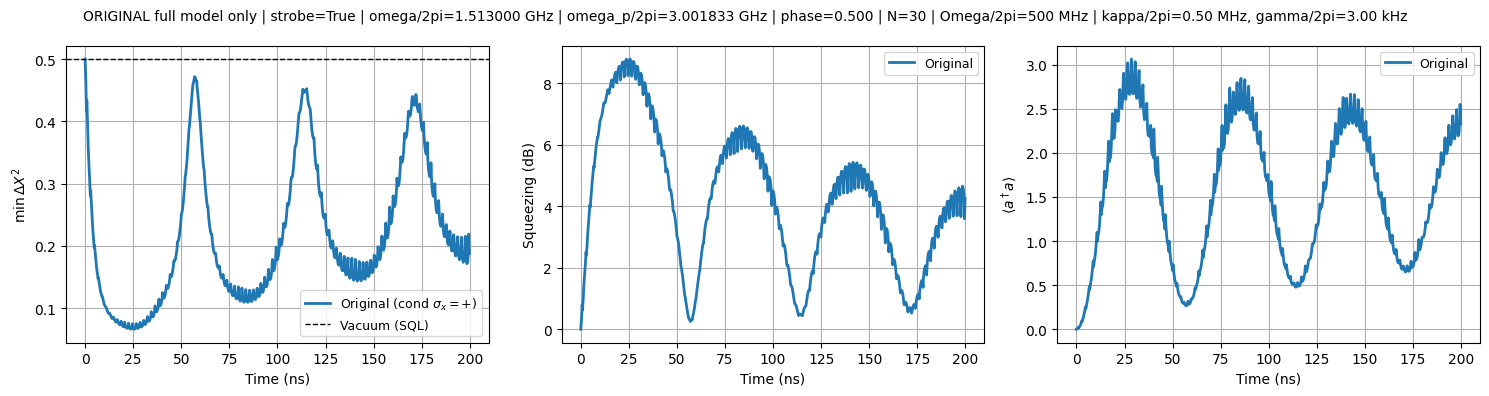

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import (
    destroy, qeye, tensor, basis, sigmax, sigmaz, sigmap, sigmam,
    mesolve, Options, ket2dm
)

# ------------------------------------------------------------
# Utilities
# ------------------------------------------------------------
def thermal_occupancy(omega, T):
    """Bose-Einstein n_th for angular frequency omega at temperature T (Kelvin)."""
    if T <= 0:
        return 0.0
    hbar = 1.054_571_817e-34
    kB = 1.380_649e-23
    x = hbar * omega / (kB * T)
    if x > 100:
        return 0.0
    return 1.0 / (np.exp(x) - 1.0)


def squeezing_metrics_from_moments(a, rho_m):
    """
    Return (vmin, sq_db, nbar) using only <a>, <a^2>, <a†a>.
    vmin = 1/2 + ( <a†a> - |<a>|^2 ) - | <a^2> - <a>^2 |
    sq_db = -10 log10(2 vmin)
    """
    alpha = (a * rho_m).tr()
    nbar  = ((a.dag() * a) * rho_m).tr()
    a2    = ((a * a) * rho_m).tr()

    alpha = complex(alpha)
    nbar  = float(np.real(nbar))
    a2    = complex(a2)

    n_c = nbar - (abs(alpha) ** 2)
    m_c = a2 - (alpha ** 2)

    vmin = 0.5 + n_c - abs(m_c)
    vmin = float(np.real(vmin))
    vmin = max(vmin, 1e-14)

    sq_db = float(-10.0 * np.log10(2.0 * vmin))
    return vmin, sq_db, nbar


def conditional_magnon_state_from_total(rho_tot, P_full, eps=1e-15, renormalize=True):
    """
    Projective measurement on total space:
      p = Tr(P rho)
      rho_post = (P rho P)/p
      rho_m = Tr_qubit[rho_post]
    """
    p = float(np.real((P_full * rho_tot).tr()))
    p_safe = max(p, eps)

    rho_post = (P_full * rho_tot * P_full) / p_safe
    rho_m = rho_post.ptrace(0)

    if renormalize:
        trm = complex(rho_m.tr())
        if abs(trm) > eps:
            rho_m = rho_m / trm

    return p, rho_m


def stroboscopic_indices(tlist, omega_p, phase_frac=0.0):
    """
    Indices where omega_p t ~ 2πk + 2π*phase_frac.
    phase_frac in [0,1).
    """
    phase = 2.0 * np.pi * phase_frac
    T = 2.0 * np.pi / omega_p
    kmax = int(np.floor((tlist[-1] - (phase / omega_p)) / T))
    targets = (phase / omega_p) + np.arange(kmax + 1) * T
    targets = targets[(targets >= tlist[0]) & (targets <= tlist[-1])]

    idx = []
    for tt in targets:
        idx.append(int(np.argmin(np.abs(tlist - tt))))
    return np.unique(idx)


# ------------------------------------------------------------
# Full (original) model only
# ------------------------------------------------------------
class FullModel:
    """
    ORIGINAL:
      H(t)= ω a†a - (ν/2) σz + gx(a+a†)σx + gz(a+a†)σz + Ω cos(ωp t + φ) σx
    """
    def __init__(self, N=30, T=10e-3):
        self.N = int(N)
        self.T = float(T)
        self._init_operators()

    def _init_operators(self):
        self.a = destroy(self.N)
        self.a_full = tensor(self.a, qeye(2))

        self.sx = tensor(qeye(self.N), sigmax())
        self.sz = tensor(qeye(self.N), sigmaz())
        self.sp = tensor(qeye(self.N), sigmap())
        self.sm = tensor(qeye(self.N), sigmam())

        # projectors for sigma_x measurement
        P_plus  = (qeye(2) + sigmax()) / 2
        P_minus = (qeye(2) - sigmax()) / 2
        self.Psx_plus_full  = tensor(qeye(self.N), P_plus)
        self.Psx_minus_full = tensor(qeye(self.N), P_minus)

    def set_params(self, *, omega, nu, omega_p, Omega, gx, gz, kappa, gamma):
        self.omega   = float(omega)
        self.nu      = float(nu)
        self.omega_p = float(omega_p)
        self.Omega   = float(Omega)
        self.gx      = float(gx)
        self.gz      = float(gz)
        self.kappa   = float(kappa)
        self.gamma   = float(gamma)

        self.n_th_m = thermal_occupancy(self.omega, self.T)
        self.n_th_q = thermal_occupancy(self.nu, self.T)

    def collapse_ops(self):
        c_ops = []

        # magnon thermal damping
        if self.kappa > 0:
            n = self.n_th_m
            c_ops.append(np.sqrt(self.kappa * (n + 1.0)) * self.a_full)
            if n > 0:
                c_ops.append(np.sqrt(self.kappa * n) * self.a_full.dag())

        # qubit thermal relaxation
        if self.gamma > 0:
            nq = self.n_th_q
            c_ops.append(np.sqrt(self.gamma * (nq + 1.0)) * self.sm)
            if nq > 0:
                c_ops.append(np.sqrt(self.gamma * nq) * self.sp)

        return c_ops

    def initial_state_total(self):
        # (|g> + |e>)/sqrt(2) ⊗ |0>
        psi_q = (basis(2, 0) + basis(2, 1)).unit()
        return tensor(basis(self.N, 0), psi_q)

    def H_original(self, phase_frac=0.0):
        # time-independent part
        H0 = (
            self.omega * self.a_full.dag() * self.a_full
            - 0.5 * self.nu * self.sz
            + self.gx * (self.a_full + self.a_full.dag()) * self.sx
            + self.gz * (self.a_full + self.a_full.dag()) * self.sz
        )

        # drive term on sx
        H1 = self.sx
        phase = 2.0 * np.pi * phase_frac

        def drive_coeff(t, args):
            return args["Omega"] * np.cos(args["omega_p"] * t + args["phase"])

        H = [H0, [H1, drive_coeff]]
        args = {"Omega": self.Omega, "omega_p": self.omega_p, "phase": phase}
        return H, args

    def evolve_original(self, tlist, phase_frac=0.0, nsteps=650000):
        H, args = self.H_original(phase_frac=phase_frac)
        psi0 = self.initial_state_total()
        c_ops = self.collapse_ops()
        opts = {
            'nsteps': int(nsteps), 
            'atol': 1e-8, 
            'rtol': 1e-6, 
            'method': "adams"
        }
        res = mesolve(H, psi0, tlist, c_ops, e_ops=[], args=args, options=opts)
        return res.states

    def metrics_original_cond_sxplus(self, states):
        """
        For each time state rho(t) on (m ⊗ q), compute conditional on sigma_x=+:
          rho_m_cond = Tr_q[(P+ rho P+)/p]
        Return arrays: vmin, sq_db, nbar, p
        """
        vmins, sqs, nbars, ps = [], [], [], []
        P = self.Psx_plus_full

        for rho in states:
            if rho.isket:
                rho = ket2dm(rho)
            p, rho_m = conditional_magnon_state_from_total(rho, P, renormalize=True)
            vmin, sq, nbar = squeezing_metrics_from_moments(self.a, rho_m)
            vmins.append(vmin); sqs.append(sq); nbars.append(nbar); ps.append(p)

        return np.array(vmins), np.array(sqs), np.array(nbars), np.array(ps)


# ============================================================
# Main
# ============================================================
if __name__ == "__main__":

    # ---- system params ----
    N = 30
    T_bath = 10e-3

    nu = 2*np.pi*3.0e9
    g  = 2*np.pi*150e6
    theta = np.pi/4
    gx = g*np.sin(theta)
    gz = g*np.cos(theta)

    Omega = 2*np.pi*500e6
    kappa = 2*np.pi*0.5e6
    gamma = 2*np.pi*3.0e3

    # ---- best parameters (directly use, no scan) ----
    omega_best   = 2*np.pi*1.5129999999999997e9
    omega_p_best = 2*np.pi*3.0018333333333334e9
    phase_best   = 0.5

    # ---- time grid (same as your final) ----
    total_time_final = 2.0e-7
    steps_final = 1100
    tlist = np.linspace(0.0, total_time_final, steps_final)

    # ---- strobe sampling ----
    USE_STROBE = True
    STROBE_PHASE_DEFAULT = 0.0

    # ---- run ----
    sim = FullModel(N=N, T=T_bath)
    sim.set_params(
        omega=omega_best, nu=nu,
        omega_p=omega_p_best, Omega=Omega,
        gx=gx, gz=gz,
        kappa=kappa, gamma=gamma
    )

    print("\n=== Running ORIGINAL full model only ===")
    print("omega/2pi (GHz)   =", omega_best/(2*np.pi*1e9))
    print("omega_p/2pi (GHz) =", omega_p_best/(2*np.pi*1e9))
    print("phase_frac        =", phase_best)

    states_ori = sim.evolve_original(tlist, phase_frac=phase_best, nsteps=650000)
    v_ori, s_ori, n_ori, p_ori = sim.metrics_original_cond_sxplus(states_ori)

    # ---- choose plot indices ----
    if USE_STROBE:
        idx = stroboscopic_indices(tlist, omega_p_best, phase_frac=STROBE_PHASE_DEFAULT)
        if len(idx) < 6:
            raise RuntimeError("Too few stroboscopic samples. Try USE_STROBE=False or adjust time grid.")
    else:
        idx = np.arange(len(tlist), dtype=int)

    t_plot = tlist[idx] * 1e9  # ns
    v_plot = v_ori[idx]
    s_plot = s_ori[idx]
    n_plot = n_ori[idx]
    p_plot = p_ori[idx]

    print("[cond] mean p =", float(np.mean(p_plot)), "min p =", float(np.min(p_plot)))

    # ---- plots: 1x3 (same style) ----
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

    ax = axes[0]
    ax.plot(t_plot, v_plot, lw=2, label=r"Original (cond $\sigma_x=+$)")
    ax.axhline(0.5, color="k", ls="--", lw=1, label="Vacuum (SQL)")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel(r"$\min\,\Delta X^2$")
    ax.grid(True)
    ax.legend(loc="best", fontsize=9)

    ax = axes[1]
    ax.plot(t_plot, s_plot, lw=2, label="Original")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Squeezing (dB)")
    ax.grid(True)
    ax.legend(loc="best", fontsize=9)

    ax = axes[2]
    ax.plot(t_plot, n_plot, lw=2, label="Original")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel(r"$\langle a^\dagger a\rangle$")
    ax.grid(True)
    ax.legend(loc="best", fontsize=9)

    fig.suptitle(
        f"ORIGINAL full model only | strobe={USE_STROBE} | "
        f"omega/2pi={omega_best/(2*np.pi*1e9):.6f} GHz | "
        f"omega_p/2pi={omega_p_best/(2*np.pi*1e9):.6f} GHz | "
        f"phase={phase_best:.3f} | N={N} | Omega/2pi={Omega/(2*np.pi*1e6):.0f} MHz | "
        f"kappa/2pi={kappa/(2*np.pi*1e6):.2f} MHz, gamma/2pi={gamma/(2*np.pi*1e3):.2f} kHz",
        fontsize=10
    )
    plt.tight_layout()
    plt.show()
